# Detector network workflow

Tested with Python 3.6.7 (from miniconda)

## Part 0. Dependencies

In [1]:
%%bash

pip install numpy seaborn sklearn-evaluation tensorflow
pip install git+git://github.com/edublancas/dstools
pip install git+git://github.com/paninski-lab/yass@8ddce299fe52901af0b35f3a49dda86f61ca2c6e

  Using cached https://files.pythonhosted.org/packages/ff/7f/9d804d2348471c67a7d8b5f84f9bc59fd1cefa148986f2b74552f8573555/numpy-1.15.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/22/cc/ca70b78087015d21c5f3f93694107f34ebccb3be9624385a911d4b52ecef/tensorflow-1.12.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e1/d8/feeb346d41f181e83fba45224ab14a8d8af019b48af742e047f3845d8cff/pandas-0.23.4-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/67/e6/6d4edaceee6a110ecf6f318482f5229792f143e468b34a631f5a0899f56d/scipy-1.2.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/71/07/16d781df15be30df4acfd536c479268f1208b2dfbc91e9ca5d92c9caf673/matplotlib-3.0.2-cp36-cp36m-manylinux1_x86_64.wh

In [21]:
%%bash

mkdir -p /tmp/spike-sorting
curl https://dl.dropboxusercontent.com/s/sylnygjmcvkmi4z/templates.npy?dl=0 -o /tmp/spike-sorting/templates.npy
curl https://dl.dropboxusercontent.com/s/smk83ob73y9z7p0/config.yaml?dl=0 -o /tmp/spike-sorting/config.yaml
curl https://dl.dropboxusercontent.com/s/mfp5vcu9b53ws91/noise_cov.npz?dl=0 -o /tmp/spike-sorting/noise_cov.npz
curl https://dl.dropboxusercontent.com/s/k9qa7vttuzrsmr4/geometry.txt?dl=0 -o /tmp/spike-sorting/geometry.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2802k  100 2802k    0     0  2861k      0 --:--:-- --:--:-- --:--:-- 2859k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   274  100   274    0     0    581      0 --:--:-- --:--:-- --:--:--   581
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 30652  100 30652    0     0  51634      0 --:--:-- --:--:-- --:--:-- 51689
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   680  100   680    0     0   1431      0 --:--:-- --:--:-- --:--:--  1428


## Part 1. Train/Test set creation

In [3]:
import datetime
import logging
from pathlib import Path
from os.path import expanduser
from os import path

import yass
from yass import read_config
from yass.augment import make
from yass.neuralnetwork import NeuralNetDetector
from yass.batch import RecordingsReader
from yass.augment.noise import noise_cov
from yass.templates import TemplatesProcessor
from yass.geometry import make_channel_index


import seaborn as sns
import numpy as np
from dstools import plot
import sklearn_evaluation.plot as skplot

# logging.basicConfig(level=logging.DEBUG)

Using TensorFlow backend.


In [4]:
path_to_data = expanduser('~/data')
path_to_experiment = path.join(path_to_data, 'retinal/sample_output')
path_to_standarized = path.join(path_to_experiment,
                                'preprocess', 'standarized.bin')

In [22]:
yass.set_config('/tmp/spike-sorting/config.yaml',
                '/tmp/spike-sorting/output')
CONFIG = read_config()

### 1.1 Loading templates

In [23]:
raw_templates = np.load('/tmp/spike-sorting/templates.npy')
n_templates, waveform_length, _ = raw_templates.shape
print(raw_templates.shape)

(240, 61, 49)


In [7]:
# crop templates spatially
processor = TemplatesProcessor(raw_templates)
templates = (processor
            .crop_spatially(CONFIG.neigh_channels, CONFIG.geom)
            .values)
templates.shape

(240, 61, 7)

/home/Edu/miniconda3/envs/py36/lib/python3.6/site-packages/dstools/plot/plot.py:63: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data[slicer]


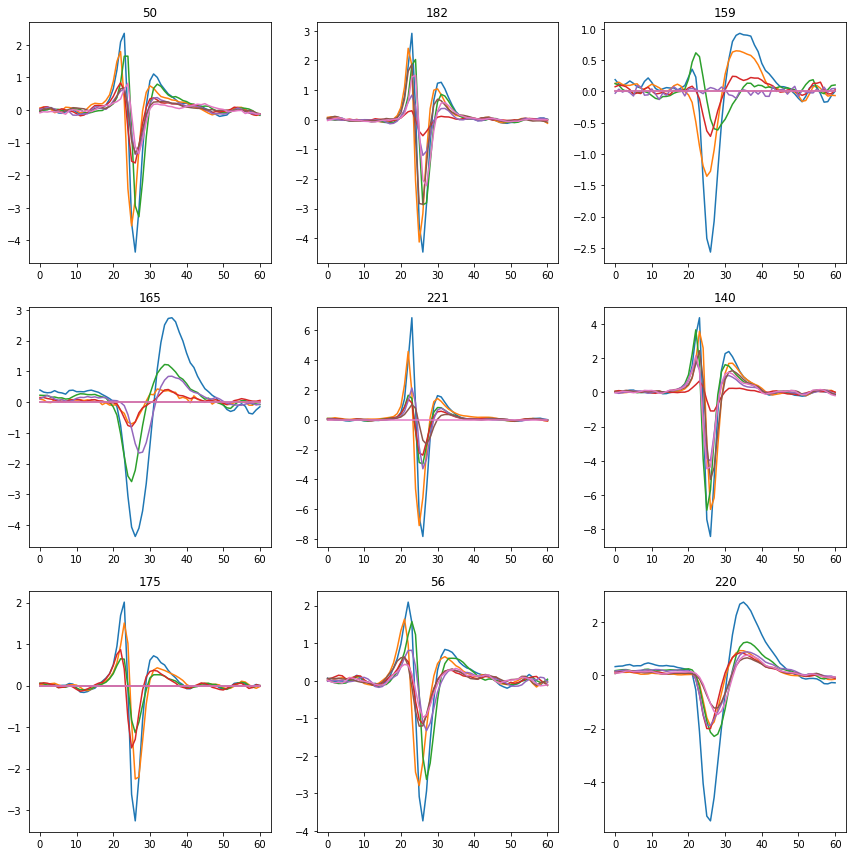

In [8]:
plot.grid_from_array(templates, axis=0, auto_figsize=4,
                     max_cols=3, elements=9)

### 1.2 Estimating noise covariance structure

In [9]:
ch_idx = make_channel_index(CONFIG.neigh_channels, CONFIG.geom)
selected_channels = ch_idx[0]
selected_channels

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

In [24]:
LOAD_NOISE_COV = True


if LOAD_NOISE_COV:
    cov = np.load('/tmp/spike-sorting/noise_cov.npz')
    spatial_sig, temporal_sig = cov['spatial_sig'], cov['temporal_sig']
else:
    rec = RecordingsReader(path_to_standarized, loader='array').data[:, selected_channels]
    (spatial_sig,
     temporal_sig) = noise_cov(rec, templates.shape[1], templates.shape[1])

In [11]:
min_amplitude = 4
max_amplitude = 60
n_clean_per_template = 200
n_positive_total = n_templates *  n_clean_per_template
n_collided_per_spike = 0
probs = [0.6, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]

### 1.3 Create dataset

In [13]:
X, y = make.training_data_detect(templates=templates,
                                 minimum_amplitude=min_amplitude,
                                 maximum_amplitude=max_amplitude,
                                 n_clean_per_template=n_clean_per_template,
                                 n_collided_per_spike=n_collided_per_spike,
                                 n_temporally_misaligned_per_spike=0.25,
                                 n_noise=int(n_positive_total * 0.5),
                                 n_spatially_misaliged_per_spike=0,
                                 spatial_SIG=spatial_sig,
                                 temporal_SIG=temporal_sig,
                                 add_noise_kwargs={'reject_cancelling_noise': False},
                                 from_templates_kwargs={'probabilities': probs})

In [14]:
X[y == 1].shape, X[y == 0].shape

((48000, 61, 7), (36000, 61, 7))

### 1.4 Plot some examples

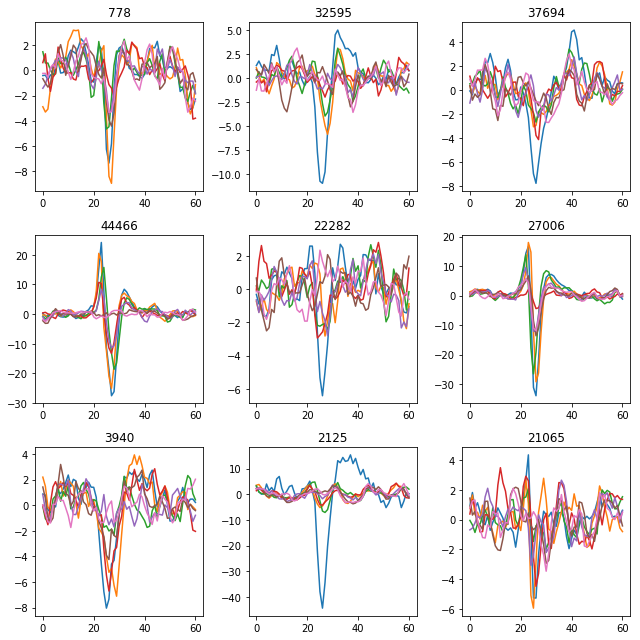

In [15]:
# positive examples (spikes)
plot.grid_from_array(X[y == 1], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

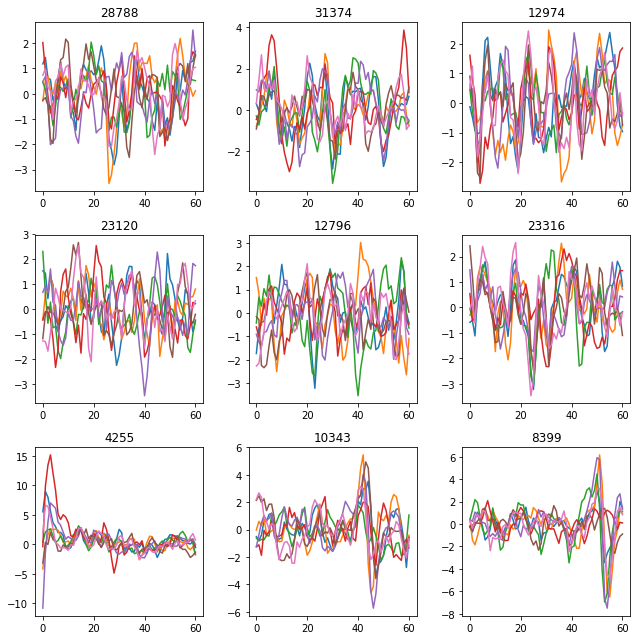

In [16]:
# negative examples: noise and non-centered spikes
plot.grid_from_array(X[y == 0], axis=0,
                     elements=9, auto_figsize=3,
                     sharey=False)

## Part 2. Network training

In [17]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.0001
filters_detect = [32, 32]

In [25]:
_, waveform_length, n_neighbors =  X.shape

detector = NeuralNetDetector('/tmp/spike-sorting/my-detector-network.ckpt', filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(X, y)

Tr loss: 4.2906653e-05, Val loss: 0.010797962: 100%|██████████| 5000/5000 [00:53<00:00, 94.18it/s] 


{'filters_size': [32, 32],
 'waveform_length': 61,
 'n_neighbors': 7,
 'name': 'my-detector-network',
 'tn': 0.9970312644957788,
 'fp': 0.0022189862006795646,
 'fn': 0.0029687355042211706,
 'tp': 0.9977810137993204,
 'acc': 0.9974603174603175,
 'prec': 0.9977810137993204,
 'rec': 0.9977810137993204,
 'metadata': {'yass_version': '0.10dev'}}

### Part 3. Network evaluation

In [19]:
preds = detector.predict(detector.x_test)

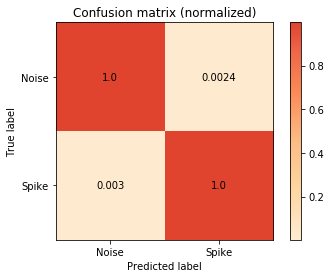

In [20]:
skplot.confusion_matrix(detector.y_test, preds, normalize=True, target_names=['Noise', 'Spike'])

### Part 4. cleanup

In [ ]:
! rm -rf /tmp/spike-sorting